🔹 Loading neural responses ...
Data shape: 39209×118×50×1
Averaged responses: (39209, 118)
🔹 Loading ViT labels ...
Found 118 scene labels.
🔹 Running PCA ...
Selecting 80 PCs to cover 90% of variance (90.17%)
Saving PC1/80 ...


IndexError: list index out of range

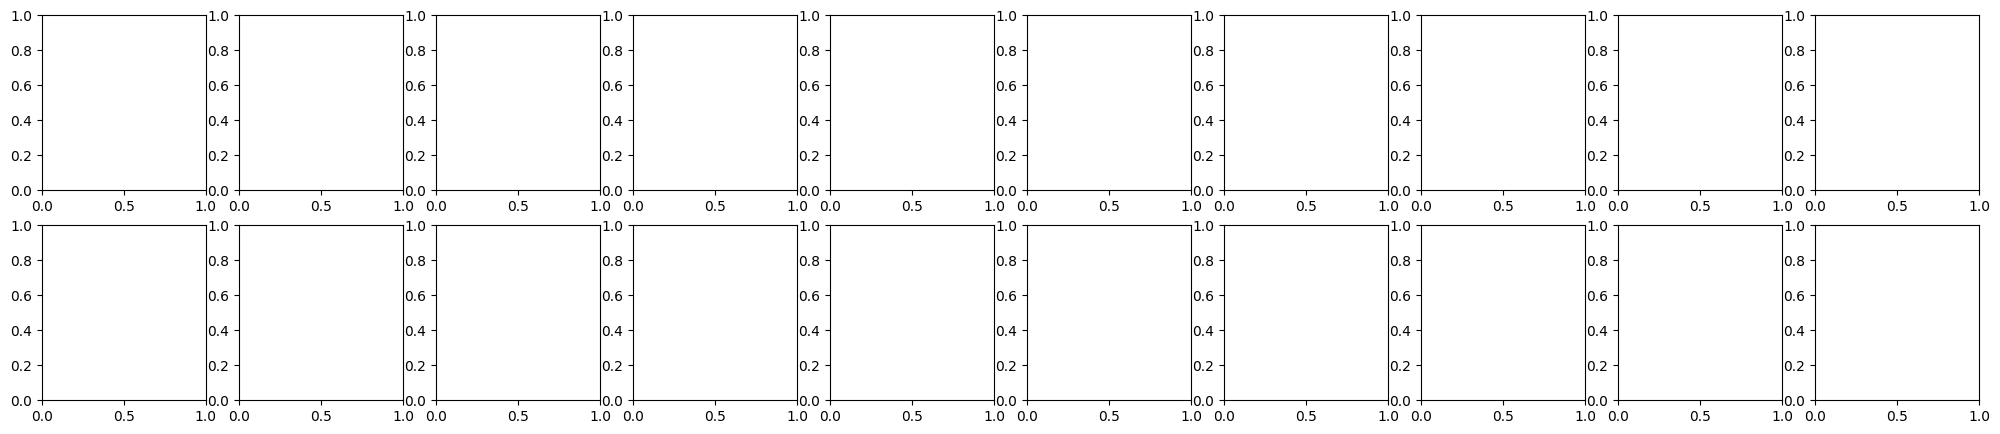

In [ ]:
#!/usr/bin/env python3
"""
Full PCA interpretability atlas for Mouse Neural Responses (ViT-style).

For each PC:
 - Plotly bar chart (top ±10 scenes)
 - Matplotlib mosaic of top 10 and bottom 10 image thumbnails
 - Builds combined index.html for browsing all PCs
"""

import os, pickle, numpy as np, matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from PIL import Image
import plotly.graph_objects as go

# ---------------------------------------------------------------
# CONFIG
# ---------------------------------------------------------------
NEURAL_PATH = '/home/maria/LuckyMouse/pixel_transformer_neuro/data/processed/hybrid_neural_responses.npy'
VIT_PATH = '/home/maria/Documents/HuggingMouseData/MouseViTEmbeddings/google_vit-base-patch16-224_embeddings_logits.pkl'
IMGS_PATH = '/home/maria/MITNeuralComputation/vit_embeddings/images'
top_k = 10
out_dir = 'mouse_pca_panels'
os.makedirs(out_dir, exist_ok=True)

# ---------------------------------------------------------------
# LOAD NEURAL DATA
# ---------------------------------------------------------------
print("🔹 Loading neural responses ...")
dat = np.load(NEURAL_PATH)  # shape: (neurons, 118 * 50 * 5900)
n_neurons, n_total = dat.shape
n_images, n_trials = 118, 50
n_time = n_total // (n_images * n_trials)
print(f"Data shape: {n_neurons}×{n_images}×{n_trials}×{n_time}")

# reshape → average across trials and time
dat = dat.reshape(n_neurons, n_images, n_trials, n_time)
X_mean = dat.mean(axis=(2, 3))  # (neurons × images)
print("Averaged responses:", X_mean.shape)

# ---------------------------------------------------------------
# LOAD ViT LABELS (for scene names)
# ---------------------------------------------------------------
print("🔹 Loading ViT labels ...")
try:
    from torchvision.models import vit_b_16, ViT_B_16_Weights
    class_names = ViT_B_16_Weights.IMAGENET1K_V1.meta["categories"]
except Exception:
    class_names = [f"class_{i}" for i in range(1000)]

with open(VIT_PATH, 'rb') as f:
    vit_logits = pickle.load(f)['natural_scenes']

top1_idx = np.argmax(vit_logits, axis=1)
scene_labels = [class_names[i] for i in top1_idx]
image_ids = [f"scene_{i:03d}" for i in range(n_images)]
print(f"Found {len(scene_labels)} scene labels.")

# ---------------------------------------------------------------
# PCA
# ---------------------------------------------------------------
print("🔹 Running PCA ...")
X_centered = X_mean - X_mean.mean(axis=0, keepdims=True)
pca_full = PCA(n_components=min(X_centered.shape), random_state=0)
pca_full.fit(X_centered)
cumulative_var = np.cumsum(pca_full.explained_variance_ratio_)

# Find smallest number of PCs covering ≥90% variance
n_components = np.searchsorted(cumulative_var, 0.90) + 1
print(f"Selecting {n_components} PCs to cover 90% of variance "
      f"({100*cumulative_var[n_components-1]:.2f}%)")

# Refit PCA with that number of components
pca = PCA(n_components=n_components, random_state=0)
U = pca.fit_transform(X_centered)  # neuron projections
V = pca.components_.T              # image loadings
expl_var = pca.explained_variance_ratio_

# ---------------------------------------------------------------
# Plotly: bar chart (ViT-style)
# ---------------------------------------------------------------
def plot_pc_semantics_plotly(V, class_names, pc_idx, top_k=10):
    v = V[:, pc_idx]
    pos_idx = np.argsort(v)[-top_k:][::-1]
    neg_idx = np.argsort(v)[:top_k]
    pos_names = [class_names[i] for i in pos_idx]
    neg_names = [class_names[i] for i in neg_idx]

    fig = go.Figure()
    fig.add_trace(go.Bar(
        x=v[pos_idx], y=pos_names,
        orientation='h', marker_color='green', name='Positive'
    ))
    fig.add_trace(go.Bar(
        x=v[neg_idx], y=neg_names,
        orientation='h', marker_color='red', name='Negative'
    ))
    fig.update_layout(
        title=f"PC{pc_idx+1} — top ±{top_k} scenes",
        barmode='overlay',
        xaxis_title="Loading weight",
        yaxis_title="Scene",
        template="plotly_white"
    )
    return fig

# ---------------------------------------------------------------
# Matplotlib: 10×2 image mosaic (top/bottom)
# ---------------------------------------------------------------
# ---------------------------------------------------------------
# Matplotlib: 10×2 image mosaic (top/bottom)
# ---------------------------------------------------------------
def save_top_images(V, pc_idx, image_ids, imgs_path, out_dir, top_n=10):
    """Save a mosaic of top/bottom scoring images for the given PC."""
    scores = V[:, pc_idx]  # use V (image loadings), not U (neurons)
    top_idx = np.argsort(scores)[-top_n:][::-1]
    bot_idx = np.argsort(scores)[:top_n]

    fig, axes = plt.subplots(2, top_n, figsize=(2.5 * top_n, 5))

    for i, idx in enumerate(top_idx):
        img_name = f"{image_ids[idx]}.png"
        img_path = os.path.join(imgs_path, img_name)
        if os.path.exists(img_path):
            axes[0, i].imshow(Image.open(img_path), cmap='gray')
        axes[0, i].set_title(f"Top {i+1} ({scores[idx]:.2f})", fontsize=8)
        axes[0, i].axis("off")

    for i, idx in enumerate(bot_idx):
        img_name = f"{image_ids[idx]}.png"
        img_path = os.path.join(imgs_path, img_name)
        if os.path.exists(img_path):
            axes[1, i].imshow(Image.open(img_path), cmap='gray')
        axes[1, i].set_title(f"Bottom {i+1} ({scores[idx]:.2f})", fontsize=8)
        axes[1, i].axis("off")

    plt.suptitle(f"Example images for PC{pc_idx+1} ({expl_var[pc_idx]*100:.2f}% variance)", fontsize=12)
    plt.tight_layout()
    out_path = os.path.join(out_dir, f"PC{pc_idx+1:02d}_images.png")
    plt.savefig(out_path, dpi=150)
    plt.close(fig)


# ---------------------------------------------------------------
# MAIN LOOP
# ---------------------------------------------------------------
for pc_idx in range(n_components):
    print(f"Saving PC{pc_idx+1}/{n_components} ...")

    # Plotly bar chart
    fig = plot_pc_semantics_plotly(V, scene_labels, pc_idx, top_k=top_k)
    fig.write_html(os.path.join(out_dir, f"PC{pc_idx+1:02d}_bars.html"))

    # Image mosaic
    save_top_images(V, pc_idx, image_ids, IMGS_PATH, out_dir, top_n=10)



print(f"\n✅ All {n_components} components saved in '{out_dir}/'")

# ---------------------------------------------------------------
# HTML INDEX BUILDER
# ---------------------------------------------------------------
print("🔹 Building index.html ...")
index_path = os.path.join(out_dir, "index.html")

bar_files = sorted([f for f in os.listdir(out_dir) if f.endswith("_bars.html")])
pcs = [f.split("_")[0] for f in bar_files]

html_parts = [
    "<html><head>",
    "<meta charset='utf-8'/>",
    "<title>Mouse PCA Atlas</title>",
    "<style>",
    "body { font-family: sans-serif; background-color: #f9f9f9; margin: 40px; }",
    "h2 { margin-top: 60px; }",
    "iframe { border: none; width: 100%; height: 500px; }",
    "img { width: 100%; border-radius: 8px; box-shadow: 0 2px 4px rgba(0,0,0,0.2); }",
    ".panel { background: white; padding: 20px; border-radius: 10px; margin-bottom: 40px; "
    "box-shadow: 0 0 10px rgba(0,0,0,0.05); }",
    "a { text-decoration: none; color: #3366cc; }",
    "</style></head><body>",
    "<h1>Mouse Brain PCA Interpretability Atlas</h1>",
    f"<p>Found {len(pcs)} components in <code>{out_dir}</code>.</p>",
    "<h3>Jump to component:</h3><ul>",
]

# Table of contents
for pc_prefix in pcs:
    num = pc_prefix.replace("PC", "")
    html_parts.append(f"<li><a href='#{pc_prefix}'>PC{int(num)}</a></li>")
html_parts.append("</ul>")

# Panels
for pc_prefix in pcs:
    num = pc_prefix.replace("PC", "")
    bar_html = f"{pc_prefix}_bars.html"
    img_png = f"{pc_prefix}_images.png"

    html_parts.append(f"<div class='panel' id='{pc_prefix}'>")
    html_parts.append(f"<h2>Principal Component {int(num)}</h2>")
    if os.path.exists(os.path.join(out_dir, bar_html)):
        html_parts.append(f"<iframe src='{bar_html}'></iframe>")
    if os.path.exists(os.path.join(out_dir, img_png)):
        html_parts.append(f"<img src='{img_png}' alt='PC{num} images'/>")
    html_parts.append("</div>")

html_parts.append("</body></html>")

with open(index_path, "w") as f:
    f.write("\n".join(html_parts))

print(f"✅ HTML index created: {index_path}")
